In [51]:
from geopy.distance import distance as geodesic_distance


class City:
    def __init__(self, name: str, geo_lat: float, geo_lon: float):
        self.name = name
        self.geo_lat = geo_lat
        self.geo_lon = geo_lon

    def __str__(self):
        return self.name

    def get_coordinates(self):
        return self.geo_lat, self.geo_lon

    def distance_to(self, city, units: str = 'km'):
        distance = geodesic_distance(self.get_coordinates(), city.get_coordinates())
        if units == 'km':
            return distance.km
        else:
            raise NotImplementedError

In [2]:
import pandas as pd


cities = pd.read_csv('../data/city.csv')

In [3]:
cities.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [17]:
top_n = 30

top_n_cities = cities.sort_values(by=['population'], ascending=False)[:top_n][['address', 'geo_lat', 'geo_lon']]
top_n_cities

,address,geo_lat,geo_lon
509,г Москва,55.754047,37.620405
786,г Санкт-Петербург,59.939131,30.315900
647,г Новосибирск,55.028191,82.921149
832,г Екатеринбург,56.838522,60.605491
619,г Нижний Новгород,56.324063,44.005391
927,г Казань,55.794358,49.111497
782,г Самара,53.195031,50.106952
656,г Омск,54.984857,73.367452
1064,г Челябинск,55.160262,61.400808
757,г Ростов-на-Дону,47.222457,39.718803


In [24]:
from shapely.geometry import Point
import geopandas as gpd


geometry = [Point(xy) for xy in zip(top_n_cities['geo_lon'], top_n_cities['geo_lat'])]
gdf = gpd.GeoDataFrame(top_n_cities, geometry=geometry)

<AxesSubplot:>

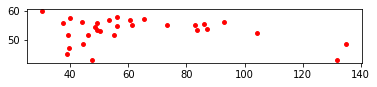

In [61]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(marker='o', color='red', markersize=15)

In [27]:
def distance_between_cities_in_order(permutation_of_cities):
    distance = 0
    for i in range(1, len(permutation_of_cities)):
        distance += permutation_of_cities[i-1].distance_to(permutation_of_cities[i])
    distance += permutation_of_cities[-1].distance_to(permutation_of_cities[0])
    return distance

In [45]:
import random


def inverse_neighbour(permutation, i, j):
    i, j = (i, j) if i < j else (j, i)
    return [permutation[i + j - t] if i <= t <= j else permutation[t] for t in range(len(permutation))]


def insert_neighbour(permutation, i, j):
    i, j = (i, j) if i < j else (j, i)
    return [permutation[j if t == i else t - 1] if i <= t <= j else permutation[t] for t in range(len(permutation))]


def swap_neighbour(permutation, i, j):
    swap = permutation.copy()
    swap[i] = permutation[j]
    swap[j] = permutation[i]
    return swap


def greedy_hybrid_neighbour(permutation, energy_fn):
    i, j = random.sample(list(range(len(permutation))), 2)
    inverse = inverse_neighbour(permutation, i, j)
    insert = insert_neighbour(permutation, i, j)
    swap = swap_neighbour(permutation, i, j)
    neighbours = (inverse, insert, swap)
    min_idx, min_energy = 0, 1e12
    for i in range(len(neighbours)):
        e = energy_fn(neighbours[i])
        if e < min_energy:
            min_idx = i
            min_energy = e
    return neighbours[min_idx], min_energy

In [68]:
import math


def find_approximately_optimal_permutation(
        permutation,
        energy_fn,
        neighbour_fn,
        initial_temp=1000,
        cooling_rate=0.003,
        start_idx=None,
        report_interval=100
):

    temp = initial_temp
    iterations_since_last_report = report_interval + 1
    while temp > 1:
        current_energy = energy_fn(permutation)
        if iterations_since_last_report > report_interval:
            print(f'Temperature: {temp:3.3f} Energy: {current_energy:7.3f}')
            iterations_since_last_report = 0
        else:
            iterations_since_last_report += 1
        new_permutation, new_energy = neighbour_fn(permutation, energy_fn)
        if new_energy < current_energy or random.uniform(0, 1) < math.exp((current_energy - new_energy) / temp):
            permutation = new_permutation
        temp *= 1 - cooling_rate
    print(f'Found optimal solution with energy: {current_energy:7.3f}')
    if start_idx is not None:
        permutation = permutation[start_idx:] + permutation[:start_idx]
    return permutation

In [69]:
list_top_n_cities = []
for i in range(len(top_n_cities)):
    list_top_n_cities.append(
        City(
            name=top_n_cities['address'].iloc[i],
            geo_lat=top_n_cities['geo_lat'].iloc[i],
            geo_lon=top_n_cities['geo_lon'].iloc[i]
        )
    )

In [70]:
good_city_order = find_approximately_optimal_permutation(list_top_n_cities, distance_between_cities_in_order, greedy_hybrid_neighbour)

Temperature: 1000.000 Energy: 65368.527
Temperature: 736.048 Energy: 29843.785
Temperature: 541.767 Energy: 23985.457
Temperature: 398.766 Energy: 21779.404
Temperature: 293.511 Energy: 20497.571
Temperature: 216.038 Energy: 21132.412
Temperature: 159.015 Energy: 20026.204
Temperature: 117.042 Energy: 19461.969
Temperature: 86.149 Energy: 18778.316
Temperature: 63.410 Energy: 18650.251
Temperature: 46.673 Energy: 18680.840
Temperature: 34.353 Energy: 18680.840
Temperature: 25.286 Energy: 18696.411
Temperature: 18.611 Energy: 18696.411
Temperature: 13.699 Energy: 18488.876
Temperature: 10.083 Energy: 18488.876
Temperature: 7.422 Energy: 18488.876
Temperature: 5.463 Energy: 18488.876
Temperature: 4.021 Energy: 18406.441
Temperature: 2.959 Energy: 18406.441
Temperature: 2.178 Energy: 18406.441
Temperature: 1.603 Energy: 18406.441
Temperature: 1.180 Energy: 18406.441
Found optimal solution with energy: 18406.441


In [72]:
for c in good_city_order:
    print(c)

г Кемерово
г Новосибирск
г Тюмень
г Екатеринбург
г Пермь
г Ижевск
г Самара
Самарская обл, г Тольятти
г Ульяновск
г Казань
г Нижний Новгород
г Ярославль
г Санкт-Петербург
г Москва
г Воронеж
г Саратов
г Волгоград
г Ростов-на-Дону
г Краснодар
г Махачкала
г Оренбург
г Уфа
г Челябинск
г Омск
г Барнаул
Кемеровская область - Кузбасс, г Новокузнецк
г Иркутск
г Владивосток
г Хабаровск
г Красноярск
